In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize_scalar, minimize
from time import time
import seaborn as sns
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [2]:
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, SmoothFirstDifference, \
    SparseFirstDiffConvex, SparseSecondDiffConvex
from osd.utilities import progress
SOLVERS = [
    'ECOS',
    'SCS',
    'OSQP',
    'MOSEK'
]

In [3]:
def run_study(data, components, seed=42):
    results = pd.DataFrame(columns=['successful', 'time_elapsed', 'residual_error',
                                    'class_cost'])
    counter = 0
    total = len(SOLVERS)
    for solver in SOLVERS:
        progress(counter, total)
        problem = Problem(data=data, components=components)
        problem.weights.value = [1, 1e2]
        ti = time()
        try:
            problem.optimize_weights(solver=solver, seed=seed)
            residual_error = problem.holdout_validation(solver=solver, seed=seed)
        except:
            success = False
            residual_error = np.nan
            class_cost = np.nan
        else:
            success = True
            class_cost = problem.components[1].cost(problem.estimates[1]).value
        tf = time()
        results.loc[solver] = [success, tf - ti, residual_error, class_cost]
        counter += 1
    progress(counter, total)
    return results

## Signal 1: Sinusoid with noise

In [4]:
np.random.seed(42)
t = np.linspace(0, 1000, 3000)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
y = signal1 + 0.25 * np.random.randn(len(signal1))

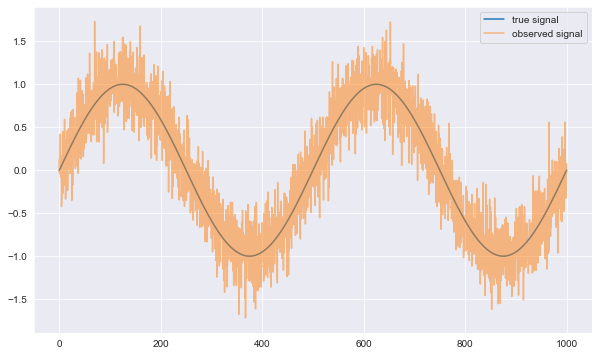

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(t, signal1, label='true signal')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

In [6]:
sinusoid_results = run_study(data=y, components=[GaussNoise, SmoothSecondDifference])
sinusoid_results

,successful,time_elapsed,residual_error,class_cost
ECOS,False,0.152411,NaN,NaN
SCS,True,348.456426,37.156056,1.0938673527157557e-06
OSQP,True,27.383743,36.979156,5.102739994716748e-07
MOSEK,True,3.379076,36.979430,5.187793786545366e-07


## Signal 2: Square wave

In [7]:
np.random.seed(42)
t = np.linspace(0, 1000, 3000)
signal1 = signal.square(2 * np.pi * t * 1 / (450.))
y = signal1 + 0.25 * np.random.randn(len(signal1))

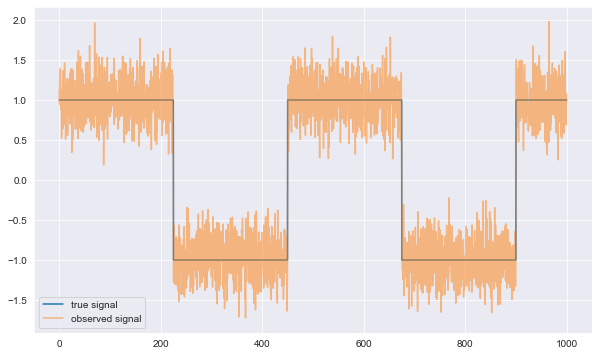

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(t, signal1, label='true signal')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

In [9]:
square_results = run_study(data=y, components=[GaussNoise, SparseFirstDiffConvex])
square_results

,successful,time_elapsed,residual_error,class_cost
ECOS,True,11.274808,38.085329,8.631487
SCS,True,65.367733,38.097378,8.319838
OSQP,True,12.836413,38.097898,8.179067
MOSEK,True,4.453739,40.401518,8.636452


## Signal 3: Triangle Wave

In [10]:
np.random.seed(42)
t = np.linspace(0, 1000, 3000)
signal1 = np.abs(signal.sawtooth(2 * np.pi * t * 1 / (500.)))
y = signal1 + 0.25 * np.random.randn(len(signal1))

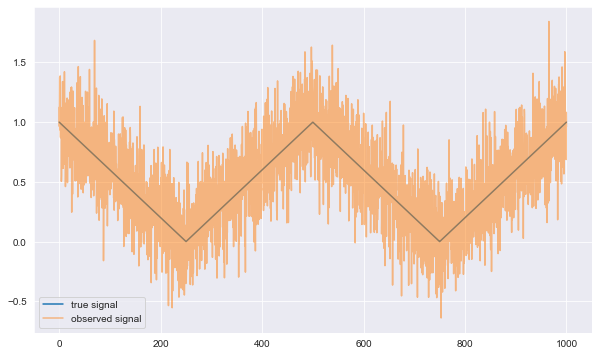

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(t, signal1, label='true signal')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

In [12]:
triangle_results = run_study(data=y, components=[GaussNoise, SparseSecondDiffConvex])
triangle_results

,successful,time_elapsed,residual_error,class_cost
ECOS,True,26.084752,36.949413,0.009649
SCS,True,241.685647,36.951768,0.094914
OSQP,True,13.297070,36.960094,0.019452
MOSEK,True,4.325585,36.949442,0.009694
